# Homework 2
Egemen Pamukcu

In the code below, I download 100 samples from gdc.cancer.gov on the TCGA stomach adenocarcinoma cancer project (TCGA-STAD). After downloading the data, I merged individual samples to come up with a feature matrix where rows are RNE-seq and columns are counts of those sequences in each sample. <br><br>

Before clustering the data, first I eliminated the RNE-seq that had less than 1000 occurrences across all samples in the dataset. Then, I used the t-SNE algorithm to reduce the dimensionality of the feature space to 2-D, which made visualization of the RNA-seq data possible. Visualization of the feature space with reduced dimensions are shown below. <br><br>

After reducing the dimensions to two, I used the resulting features to cluster the RNA-sequences into 15 clusters with K-Means, DBSCAN, and Agglomerative Clustering algorithms and visualized these clusters by labeling each RNA-seq with their corresponding cluster id's. The t-SNE algorithm did not seem to produce very distinguishable clusters of data in 2-D space, therefore each one of these clustering algorithms struggled to split the data into heterogeneous clusters. The visualizations show that most data points are cumulated close to each other (especially the t-SNE outputs that had a lower perplexity parameter). As a result, clustering of data points were not really intuitive. 

## Import Packages

In [103]:
from matplotlib import pyplot as plt
import requests
import json
import re
import gzip
import shutil
import pandas as pd
import numpy as np
from io import StringIO
import tarfile
import os
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN, KMeans, AgglomerativeClustering
from tqdm import tqdm
from sklearn.decomposition import PCA

## Load Data

### Set fiter for download

In [3]:
filters = {
    "op": "and",
    "content":[
        {
        "op": "in",
        "content":{
            "field": "cases.project.project_id",
            "value": ["TCGA-STAD"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "files.experimental_strategy",
            "value": ["RNA-Seq"]
            }
        },
        {
        "op": "in",
        "content":{
            "field": "files.data_format",
            "value": ["txt"]
            }
        },
        {
            "op": "in",
            "content":{
                "field": "files.analysis.workflow_type",
                "value": ["HTSeq - Counts"]
            }
        },
        {
            "op": "in",
            "content":{
                "field": "files.data_category",
                "value": ["transcriptome profiling"]
            }
        },
        {
            "op": "in",
            "content":{
                "field": "files.data_type",
                "value": ["Gene Expression Quantification"]
            }
        },
    ]
}

### Make a GET request

In [4]:
files_endpt = "https://api.gdc.cancer.gov/files"

# Here a GET is used, so the filter parameters should be passed as a JSON string.

params = {
    "filters": json.dumps(filters),
    "fields": "file_id",
    "format": "JSON",
    "size": "100"
    }

response = requests.get(files_endpt, params = params)

file_uuid_list = []

# This step populates the download list with the file_ids from the previous query
for file_entry in json.loads(response.content.decode("utf-8"))["data"]["hits"]:
    file_uuid_list.append(file_entry["file_id"])

data_endpt = "https://api.gdc.cancer.gov/data"

params = {"ids": file_uuid_list}

response = requests.post(data_endpt, data = json.dumps(params), headers = {"Content-Type": "application/json"})

response_head_cd = response.headers["Content-Disposition"]

file_name = re.findall("filename=(.+)", response_head_cd)[0]

with open(file_name, "wb") as output_file:
    output_file.write(response.content)

### Extract content of the .tar.gz file

In [5]:
my_tar = tarfile.open(file_name)
my_tar.extractall('./data_folder')

### Read content for all samples and combine into a singe DataFrame

In [6]:
dfs = []
i = 0
for folder in os.listdir('data_folder'):
    folder_path = os.path.join('data_folder', folder)
    if not (folder_path.endswith('.txt') | folder_path.endswith('.DS_Store')):
        for gz in os.listdir(folder_path):
            path = os.path.join(folder_path, gz)
            with gzip.open(path, 'rb') as f_in:
                c = f_in.read().decode('utf8')
            df = pd.read_csv(StringIO(c), sep='\t', names=['gene', f'sample_{i}'], index_col=0)[:-5]
            i += 1
            dfs.append(df)

In [7]:
data = pd.concat(dfs, axis=1)

## Data Exploration

Columns are samples and rows are genes

In [8]:
data.head()

,sample_0,sample_1,sample_2,sample_3,sample_4,sample_5,sample_6,sample_7,sample_8,sample_9,...,sample_90,sample_91,sample_92,sample_93,sample_94,sample_95,sample_96,sample_97,sample_98,sample_99
gene,,,,,,,,,,,,,,,,,,,,,
ENSG00000000003.13,6516,1827,1324,1431,1629,2506,1265,1107,509,1392,...,1939,6374,1057,6590,4423,1543,1816,711,3991,927
ENSG00000000005.5,0,4,11,0,1,0,2,20,4,0,...,0,1,0,1,13,1,1,0,7,1
ENSG00000000419.11,5188,3786,1543,1606,2001,1943,1019,1292,4945,1648,...,3628,12687,4253,6726,4018,2704,1785,2426,3870,2074
ENSG00000000457.12,1565,1192,506,847,1606,700,1013,449,1308,404,...,772,2018,393,744,1063,1679,1633,1590,1025,1082
ENSG00000000460.15,1165,760,117,469,559,455,596,163,696,269,...,499,1099,200,838,1143,751,649,276,854,453


### 20 most common genes:

In [9]:
data_agg = pd.DataFrame(data.sum(axis=1), columns=['sum'])

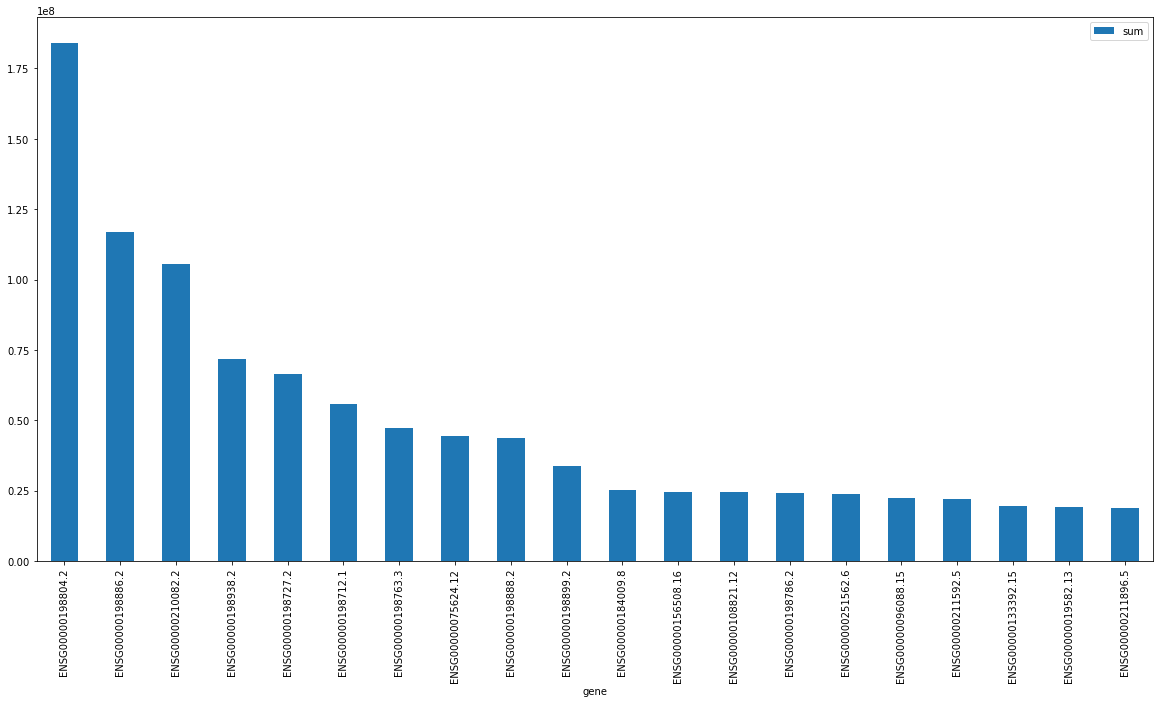

In [14]:
data_agg.sort_values('sum', ascending=False)[:20].plot(kind='bar',figsize=(20, 10));

### Histogram with logarithmic bins

In [29]:
l = list(np.logspace(0, 9, 10))
l.insert(0, 0)
l = [int(i) for i in l]
print(l)

[0, 1, 10, 100, 1000, 10000, 100000, 1000000, 10000000, 100000000, 1000000000]


In [24]:
bins = pd.cut(data_agg['sum'], bins=l, include_lowest=True, right=False)
data_agg['bins'] = bins

In [26]:
count_bins = data_agg.reset_index()[['gene', 'bins']].groupby(by='bins').count()

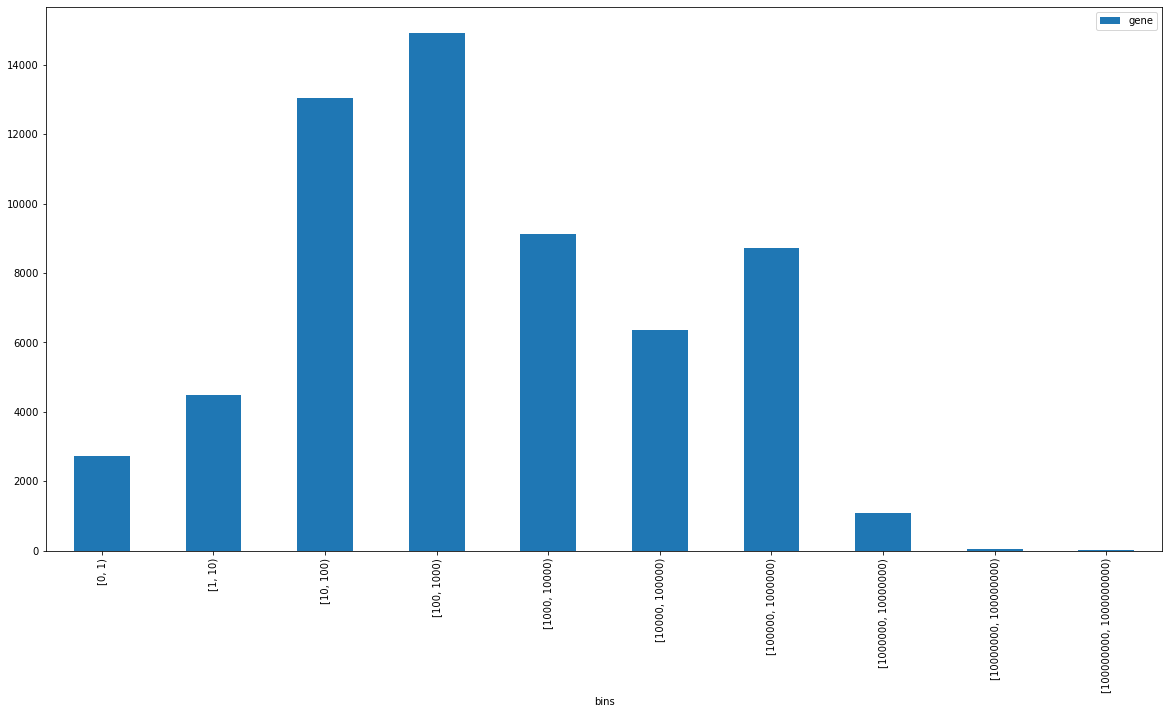

In [28]:
count_bins.plot(kind='bar', figsize=(20, 10));

## Clustering

### Remove genes appearing less than 1000 times

In [45]:
data_f = data.loc[data_agg[data_agg['sum'] > 1000].index, :]

### Dimensionality reduction with t-SNE

Iterating over possible values of perplexity takes some time:

In [55]:
X_embedded = []

In [56]:
perplexities = [5, 10, 20, 30, 40, 50]
for i in perplexities: 
    X_embedded.append(TSNE(perplexity=i).fit_transform(data_f))

#### Visualizing in 2-D

Preplexity = 5


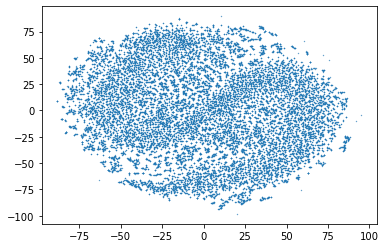

Preplexity = 10


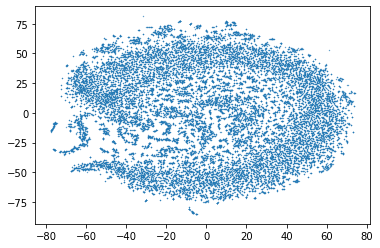

Preplexity = 20


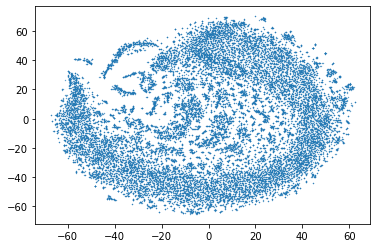

Preplexity = 30


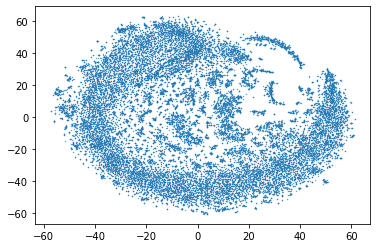

Preplexity = 40


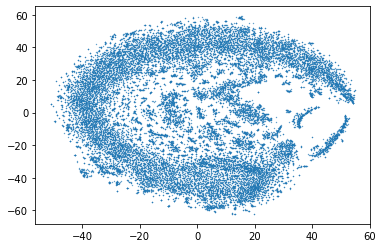

Preplexity = 50


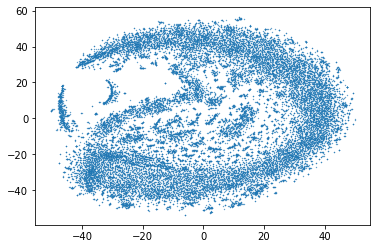

In [60]:
for i, x in enumerate(X_embedded):
    print(f'Preplexity = {perplexities[i]}')
    plt.scatter(x=x[:, 0], y=x[:, 1], s=0.1)
    plt.show()

### Clustering t-SNE output with K-Means

We will choose perplexity = 30

In [62]:
X_30 = X_embedded[3]

In [138]:
kmeans = KMeans(n_clusters=15, random_state=0).fit(X_30)
labels = kmeans.labels_

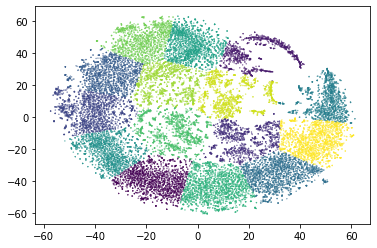

In [139]:
plt.scatter(x=X_30[:, 0], y=X_30[:, 1], s=0.1, c=labels);

### Clustering t-SNE output with DBSCAN

In [93]:
clustering = DBSCAN(min_samples=1).fit(X_30)
dbscan_labels = clustering.labels_

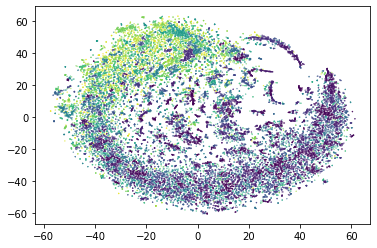

In [96]:
plt.scatter(x=X_30[:, 0], y=X_30[:, 1], s=0.1, c=dbscan_labels);

### Clustering t-SNE output with Agglomerative Clustering

  0%|          | 0/4 [00:00<?, ?it/s]

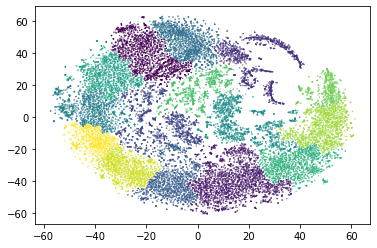

 25%|██▌       | 1/4 [01:08<03:24, 68.14s/it]

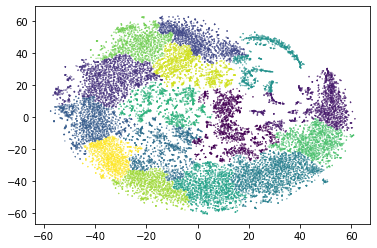

 50%|█████     | 2/4 [01:44<01:38, 49.48s/it]

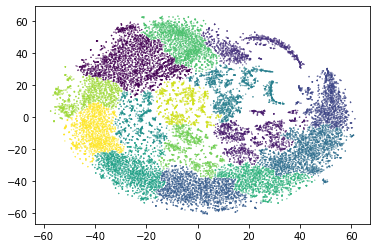

 75%|███████▌  | 3/4 [02:38<00:51, 51.33s/it]

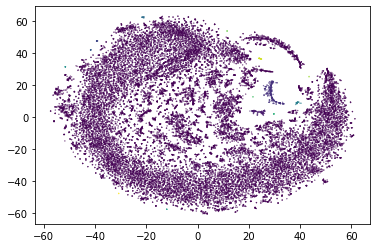

100%|██████████| 4/4 [02:41<00:00, 40.30s/it]


In [163]:
for linkage in tqdm(['ward', 'complete', 'average', 'single']):
    clustering = AgglomerativeClustering(linkage=linkage, 
                                        n_clusters=15).fit(X_30)
    ac_labels = clustering.labels_
    plt.scatter(x=X_30[:, 0], y=X_30[:, 1], s=0.1, c=ac_labels)
    plt.show()